In [1]:
import os
import matplotlib.pyplot as plt
import glob
from pathlib import Path
from lxml import etree
from nltk.tokenize import word_tokenize
from collections import Counter
import json
import pandas as pd

In [2]:
# Define the path to the corpus
path_2 = '../data/disk_images_thesis'

# 1. Exploring the corpus

In [3]:
# How many issues were captured
len(glob.glob(f'{path_2}/*/*'))

670

In [4]:
subdirs = glob.glob(f'{path_2}/*/*/')
parent_dirs = [Path(subdir).parent for subdir in subdirs]
counter = Counter(parent_dirs)
most_common_parent = counter.most_common(10)

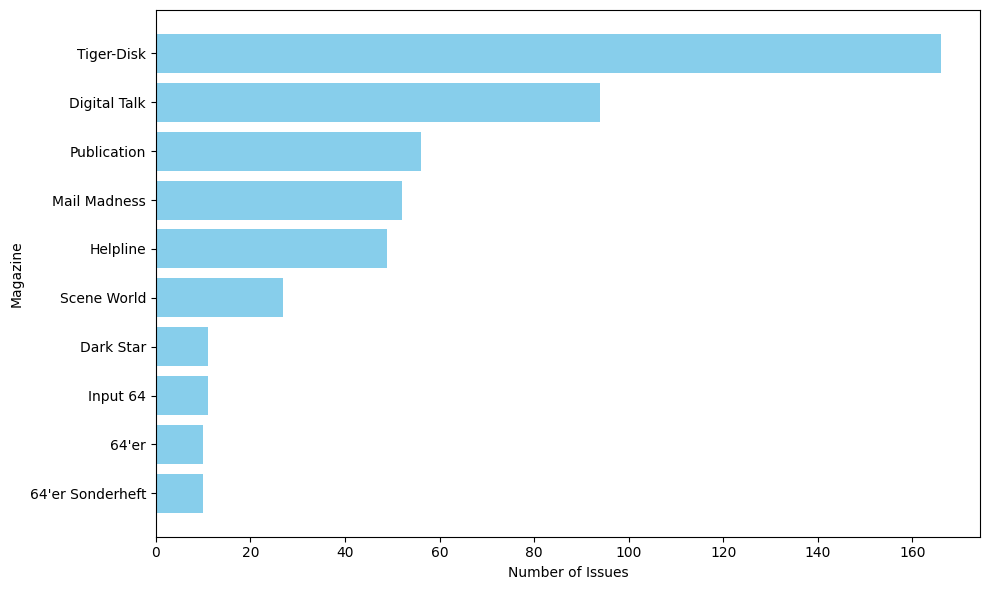

In [5]:
parent_names = [str(parent.name) for parent, count in most_common_parent]
parent_counts = [count for parent, count in most_common_parent]

plt.figure(figsize=(10, 6))
plt.barh(parent_names, parent_counts, color='skyblue')
plt.xlabel('Number of Issues')
plt.ylabel('Magazine')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [6]:
x = []
for dir in glob.glob(f'{path_2}/*'):
    subdirs = glob.glob(f'{dir}/*')
    for d in subdirs:
        files = glob.glob(os.path.join(d, '**', '*.d64'), recursive=True)
        x.append(len(files))
sum(x) / len(x)

1.8835820895522388

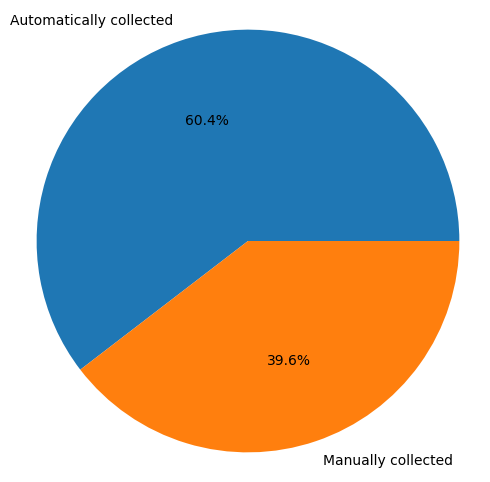

In [7]:
sizes = [29, 19]
labels = ['Automatically collected', 'Manually collected']

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%')

plt.axis('equal')

plt.show()

In [8]:
#len(glob.glob(os.path.join('data/disk_images_thesis', '**', '*.d64'), recursive=True))
len(glob.glob(os.path.join('data/disk_images_thesis', '**', '*.xml'), recursive=True))

0

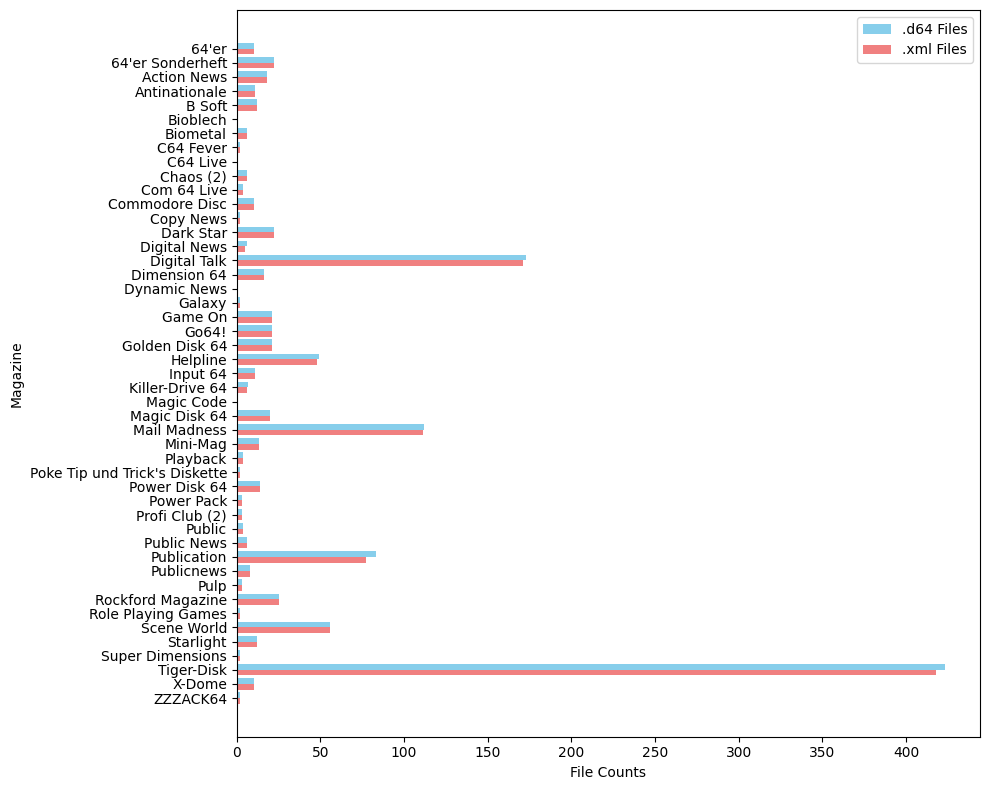

In [9]:
import numpy as np
# Initialize dictionaries to store the counts
d64_counts = {}
xml_counts = {}

# Use glob to list all magazine directories
magazine_dirs = glob.glob(f'{path_2}/*/')

# Loop through each magazine directory
for magazine_dir in magazine_dirs:
    magazine_name = Path(magazine_dir).name
    
    # List all issue directories within the current magazine directory
    issue_dirs = glob.glob(f'{magazine_dir}/*/')
    
    # Count the number of .d64 and .xml files in each issue directory
    d64_count = sum(len(glob.glob(f'{issue_dir}/*.d64')) for issue_dir in issue_dirs)
    xml_count = sum(len(glob.glob(f'{issue_dir}/*.xml')) for issue_dir in issue_dirs)
    
    d64_counts[magazine_name] = d64_count
    xml_counts[magazine_name] = xml_count

# Sort the magazines alphabetically
sorted_magazines = sorted(d64_counts.keys())
d64_file_counts = [d64_counts[magazine] for magazine in sorted_magazines]
xml_file_counts = [xml_counts[magazine] for magazine in sorted_magazines]

y = np.arange(len(sorted_magazines))

width = 0.4

fig, ax = plt.subplots(figsize=(10, 8))
rects1 = ax.barh(y - width/2, d64_file_counts, width, label='.d64 Files', color='skyblue')
rects2 = ax.barh(y + width/2, xml_file_counts, width, label='.xml Files', color='lightcoral')

# Add some text for labels, title, and custom y-axis tick labels, etc.
ax.invert_yaxis()
ax.set_xlabel('File Counts')
ax.set_ylabel('Magazine')
ax.set_yticks(y)
ax.set_yticklabels(sorted_magazines)
ax.legend()

fig.tight_layout()
plt.show()

# 2. Quantitative analysis of contents

In [10]:
xml_files = glob.glob(os.path.join('../data/disk_images_thesis', '**', '*.xml'), recursive=True)

In [11]:
namespace = ns = {'tei': 'http://www.tei-c.org/ns/1.0'}

In [12]:
entr_text = []
entr_prog = []
entr_comp = []
for file in xml_files:
    tree = etree.parse(file)
    div = len(tree.xpath('//tei:body//tei:div', namespaces=namespace))
    div_p = len(tree.xpath('//tei:body//tei:div/tei:p', namespaces=namespace))
    div_gap = len(tree.xpath('//tei:body//tei:div/tei:gap', namespaces=namespace))
    count = tree.xpath('//tei:note[@type="filetype"]/text()', namespaces=namespace)
    entropy_text = tree.xpath('//tei:noteGrp[tei:note[@type="filetype"][contains(text(), "Textdokument")]]/tei:note[@type="entropy"]/text()', namespaces=namespace)
    entropy_prog = tree.xpath('//tei:noteGrp[tei:note[@type="filetype"][contains(text(), "Programmcode")]]/tei:note[@type="entropy"]/text()', namespaces=namespace)
    entropy_comp = tree.xpath('//tei:noteGrp[tei:note[@type="filetype"][contains(text(), "Komprimierte Datei/Assembler Code")]]/tei:note[@type="entropy"]/text()', namespaces=namespace)
    entr_text.extend(entropy_text)
    entr_prog.extend(entropy_prog)
    entr_comp.extend(entropy_comp)

In [13]:
entr_text = [float(x) for x in entr_text]
entr_prog = [float(x) for x in entr_prog]
entr_comp = [float(x) for x in entr_comp]
print(sum(entr_text)/len(entr_text), sum(entr_prog)/len(entr_prog), sum(entr_comp)/len(entr_comp))

4.44834221025105 3.8190113507355465 7.715878846698431


In [14]:
entropy_overall = entr_text + entr_prog + entr_comp
entropy_overall = pd.DataFrame(entropy_overall)
entropy_overall.describe()

,0
count,50424.000000
mean,4.757801
std,1.937796
min,0.000000
25%,3.260911
50%,3.721194
75%,6.592404
max,7.992547


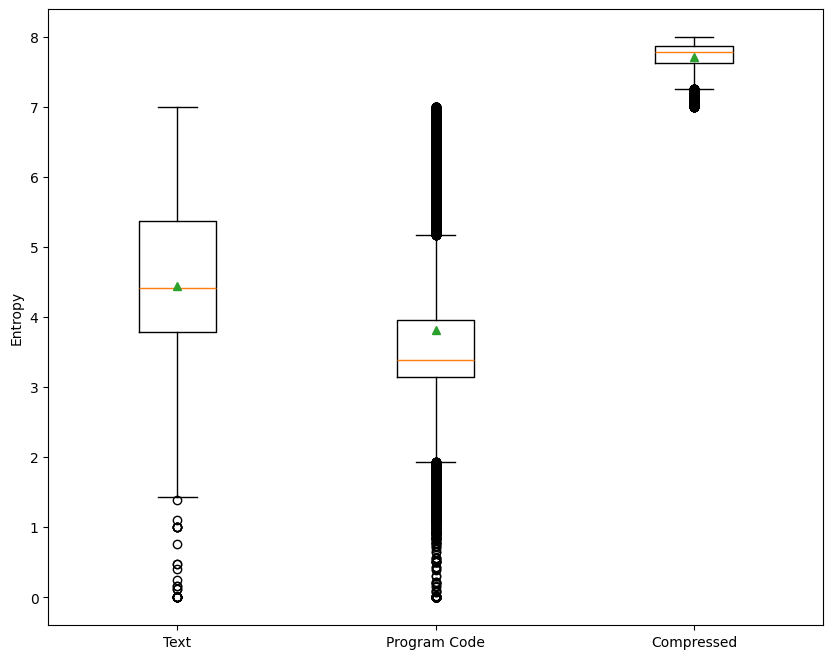

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.boxplot([entr_text, entr_prog, entr_comp], labels=['Text', 'Program Code', 'Compressed'], showmeans=True)
ax.set_ylabel('Entropy')
plt.show()

## Wordcloud

In [16]:
stopwords = open('../stopwords-de.json', encoding='utf-8')
stopwords = json.load(stopwords)

In [17]:
texts = []
for file in xml_files:
    tree = etree.parse(file)
    text = tree.xpath('//tei:body//tei:p/text()', namespaces=namespace)
    text = [elem for elem in text if len(elem) > 2]
    texts.extend(text)
texts = ' '.join(texts)

In [18]:
tokens = word_tokenize(texts, language='german')
tokens = [word.lower() for word in tokens if word.isalpha()]
stopwords = set(stopwords)
filtered_tokens = [word for word in tokens if word not in stopwords]

In [19]:
filtered_tokens = ' '.join(filtered_tokens)

In [20]:
from wordcloud import WordCloud

In [21]:
wordcloud = WordCloud(max_font_size=30, background_color="white").generate(filtered_tokens)

(-0.5, 399.5, 199.5, -0.5)

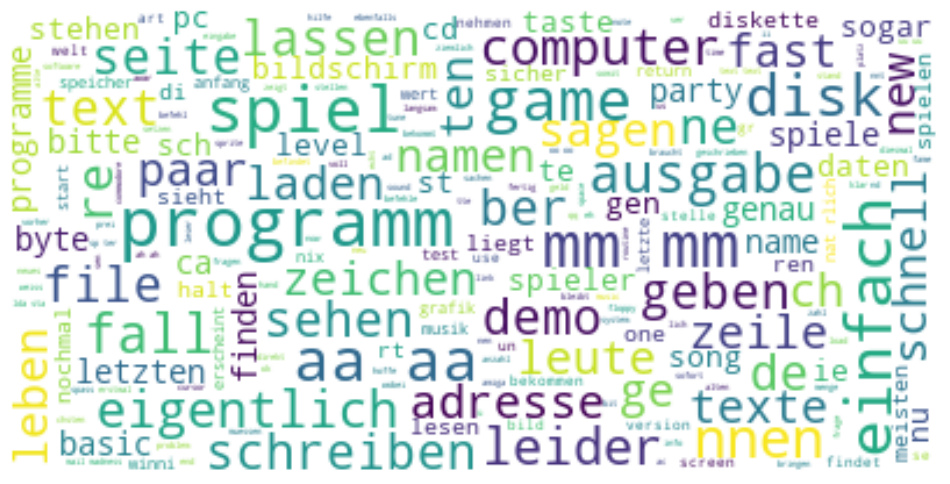

In [22]:
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')